In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
senti = pd.read_csv('/content/drive/MyDrive/ANLY-580/final_project/gme_sentiment.csv')
gme = pd.read_csv('/content/drive/MyDrive/ANLY-580/final_project/gme.csv')

In [5]:
senti_agg = senti.groupby(['date','sentiment'])[['sentiment']].count().rename(columns={'sentiment':'count'})
senti_agg['percent'] = senti_agg['count'] / senti_agg.groupby('date')['count'].sum()
senti_agg = senti_agg.reset_index()

In [6]:
senti_wide = senti_agg.pivot(index='date',columns='sentiment', values=['count','percent']).fillna(0)

In [7]:
senti_wide.reset_index(inplace=True)
senti_wide.columns = ['date','neg_count','neu_count','pos_count','%neg','%neu','%pos']
senti_wide

,date,neg_count,neu_count,pos_count,%neg,%neu,%pos
0,2021-01-01,4.0,4.0,9.0,0.235294,0.235294,0.529412
1,2021-01-02,0.0,1.0,9.0,0.000000,0.100000,0.900000
2,2021-01-03,3.0,2.0,7.0,0.250000,0.166667,0.583333
3,2021-01-04,2.0,4.0,8.0,0.142857,0.285714,0.571429
4,2021-01-05,4.0,3.0,6.0,0.307692,0.230769,0.461538
...,...,...,...,...,...,...,...
603,2022-08-27,5.0,5.0,12.0,0.227273,0.227273,0.545455
604,2022-08-28,0.0,5.0,11.0,0.000000,0.312500,0.687500
605,2022-08-29,6.0,13.0,14.0,0.181818,0.393939,0.424242
606,2022-08-30,15.0,6.0,15.0,0.416667,0.166667,0.416667


# Correlation Analysis

In [ ]:
gme['Return'] = gme.Close / gme.Open -1

merged = senti_wide.merge(gme, how='outer', left_on='date', right_on='Date').drop(columns=['Date'])
merged.fillna(method='bfill', inplace=True)
merged.dropna(inplace=True)

## Direct Correlation

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Candlestick(x=gme['Date'],
                open=gme['Open'],
                high=gme['High'],
                low=gme['Low'],
                close=gme['Close']), secondary_y=True)
fig.add_trace(go.Bar(x=merged.date,
                     y=merged.pos_count,
                     marker_color='gray',
                     visible=True), secondary_y=False)
fig.add_trace(go.Bar(x=merged.date,
                     y=merged.neg_count,
                     marker_color='gray',
                     visible=False), secondary_y=False)

button1 = dict(method='update',
               args=[{"visible": [True, True, False]}],
               label="Positive")
button2 = dict(method='update',
               args=[{"visible": [True, False, True] }],
               label="Negative")

fig.update_layout(
    title="GME Stock Price vs Reddit Sentiment",
    xaxis_title="Date",
    updatemenus=[dict(type='buttons',
                      buttons=[button1, button2],
                      direction="right",
                      xanchor="left",
                      x=0.08,
                      y=1.15,
                      yanchor="top")],
    annotations=[dict(text="Sentiment:", x=0, xref="paper", y=1.135, yref="paper",
                      align="left", showarrow=False, font=dict(size=14.5))]
)
fig.update_yaxes(title_text="Number of discussions", secondary_y=False)
fig.update_yaxes(title_text="Stock Price ($)", secondary_y=True)

fig.show()

In [ ]:
# correlation
merged[['neg_count','pos_count','%neg','%pos','Open','High','Low','Close','Return']].corr().iloc[:4, 4:]

,Open,High,Low,Close,Return
neg_count,0.190421,0.295703,0.034448,0.135550,-0.088591
pos_count,0.208103,0.294619,0.077112,0.167200,-0.049275
%neg,-0.072633,-0.063947,-0.111795,-0.103508,-0.081021
%pos,0.132717,0.102020,0.183161,0.154084,0.012134


## Direct Correlation (Smoothed)

In [ ]:
# 3-day average
merged.loc[:,['Open_avg','High_avg','Low_avg', 'Close_avg','Return_avg']] = merged[['Open','High','Low','Close','Return']].rolling(3, min_periods=1).mean().to_numpy()
merged[['neg_count','pos_count','%neg','%pos','Open_avg','High_avg','Low_avg', 'Close_avg','Return_avg']].corr().iloc[:4, 4:]

,Open_avg,High_avg,Low_avg,Close_avg,Return_avg
neg_count,0.164997,0.243624,0.035612,0.128597,-0.003135
pos_count,0.187143,0.258480,0.072598,0.157566,0.013169
%neg,-0.064149,-0.058372,-0.099738,-0.091140,-0.101963
%pos,0.143393,0.117465,0.186976,0.160782,-0.001114


## Time Lagged Cross Correlation

In [ ]:
pd.concat([merged[['neg_count','pos_count','%neg','%pos']],
           merged[['Open','High','Low', 'Close','Return']].shift(3)], axis=1).corr().iloc[:4,4:]

,Open,High,Low,Close,Return
neg_count,0.112454,0.183123,0.002548,0.069588,-0.071774
pos_count,0.143459,0.206967,0.044253,0.110450,-0.038988
%neg,-0.053496,-0.039359,-0.094069,-0.077686,-0.067056
%pos,0.166088,0.137713,0.203534,0.178016,0.005419


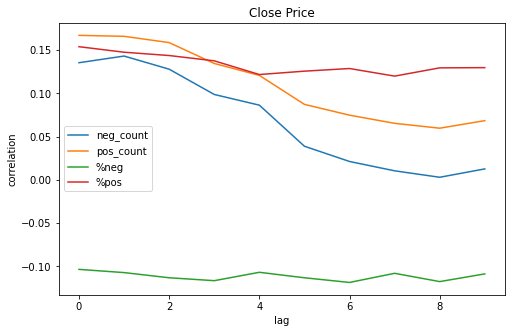

In [ ]:
import statsmodels.api as sm

#calculate cross correlation
cc = pd.DataFrame({c: sm.tsa.stattools.ccf(merged.Close, merged[c], adjusted=True)[:10] for c in ['neg_count','pos_count','%neg','%pos']})
cc.plot(figsize=(8,5))
plt.xlabel('lag')
plt.ylabel('correlation')
plt.title('Close Price')
plt.show()

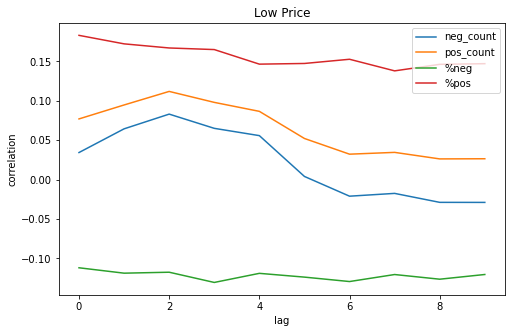

In [ ]:
pd.DataFrame({c: sm.tsa.stattools.ccf(merged.Low, merged[c], adjusted=True)[:10] for c in ['neg_count','pos_count','%neg','%pos']}).plot(figsize=(8,5))
plt.xlabel('lag')
plt.ylabel('correlation')
plt.title('Low Price')
plt.show()

# Price Movement Prediction

In [73]:
indicators = pd.read_csv('/content/drive/MyDrive/ANLY-580/final_project/gme_indicators.csv')
indicators['Date'] = pd.to_datetime(indicators.Date).astype(str)

merged_df = senti_wide.merge(indicators.drop(columns=['stock']), 
                             left_on='date', right_on='Date', 
                             how='left').drop(columns=['Date'])

In [74]:
# prepare training data blocks (window size=14)
train_data_len = int(len(merged_df)*0.8)

# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(merged_df[['pos_count','mom','rsi','natr','cci','obv','adx','increase']])

train_set = scaled_data[0: train_data_len, :]

w = 14
X_train, y_train = [], []

for i in range(w, len(train_set)):
    X_train.append(train_set[i-w:i, :-1])
    y_train.append(train_set[i,-1])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], scaled_data.shape[1]-1))

In [75]:
test_set = scaled_data[(train_data_len-w):,:]

X_test = []
y_test = scaled_data[train_data_len:,-1]


for i in range(w, len(test_set)):
    X_test.append(test_set[i-w:i, :-1])

X_test = np.array(X_test)
x_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], scaled_data.shape[1]-1))

In [76]:
# LSTM
model = keras.Sequential()
model.add(layers.LSTM(8, return_sequences=True, input_shape=(X_train.shape[1], scaled_data.shape[1]-1)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(16, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(8, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 14, 8)             512       
                                                                 
 dropout_30 (Dropout)        (None, 14, 8)             0         
                                                                 
 batch_normalization_30 (Bat  (None, 14, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_31 (LSTM)              (None, 14, 16)            1600      
                                                                 
 dropout_31 (Dropout)        (None, 14, 16)            0         
                                                                 
 batch_normalization_31 (Bat  (None, 14, 16)           64        
 chNormalization)                                    

In [77]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10, 
                    batch_size=32)


Epoch 1/20
15/15 [==============================] - 12s 277ms/step - loss: 0.8023 - accuracy: 0.5021 - val_loss: 0.6909 - val_accuracy: 0.5328
Epoch 2/20
15/15 [==============================] - 0s 23ms/step - loss: 0.7407 - accuracy: 0.5339 - val_loss: 0.6903 - val_accuracy: 0.5328
Epoch 3/20
15/15 [==============================] - 0s 24ms/step - loss: 0.7536 - accuracy: 0.4979 - val_loss: 0.6899 - val_accuracy: 0.5328
Epoch 4/20
15/15 [==============================] - 0s 24ms/step - loss: 0.7142 - accuracy: 0.5466 - val_loss: 0.6898 - val_accuracy: 0.5328
Epoch 5/20
15/15 [==============================] - 0s 25ms/step - loss: 0.7110 - accuracy: 0.5593 - val_loss: 0.6900 - val_accuracy: 0.5328
Epoch 6/20
15/15 [==============================] - 0s 25ms/step - loss: 0.6887 - accuracy: 0.5508 - val_loss: 0.6905 - val_accuracy: 0.5328
Epoch 7/20
15/15 [==============================] - 0s 24ms/step - loss: 0.6972 - accuracy: 0.5784 - val_loss: 0.6908 - val_accuracy: 0.5328
Epoch 8/20


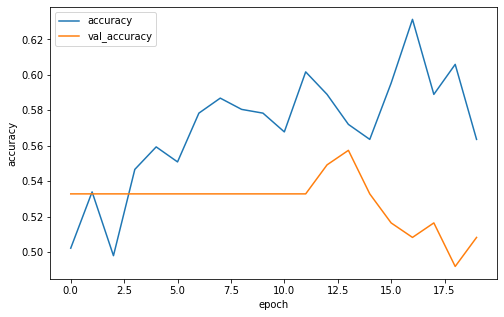

In [78]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(8,5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()